In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%matplotlib inline

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon


In [6]:
def read_data_nemo(filename_nemo):    
    filenc = filename_nemo
    xds = xr.open_dataset(filenc, engine='netcdf4', lock=False)
    ssh = xds.zeta[0,:,:]
    lat = xds.lat_rho
    lon = xds.lon_rho
    sshm_hi = ssh.to_masked_array()
    lat_hi = lat.to_masked_array()
    lon_hi = lon.to_masked_array()
    return sshm_hi, lat_hi, lon_hi

In [7]:
def plot_2_map(lon1, lat1, var1, lon2, lat2, var2, box, vmin, vmax, cmap):
    """
    Plots a 1x2 figure using scatter and basemap, and with a common colorbar showing 
    horizontally underneath the plots.
    Input variables:
    - lon1 = longitude of the left plot
    - lat1 = latitude of the left plot
    - var1 = variable of the left plot
    - lon2 = longitude of the right plot
    - lat2 = latitude of the right plot
    - var2 = variable of the right plot
    - box = box region of the area wanted to be shown
    , where box is a 1 x 4 array: 
    [minimum_longitude maximum_longitude minimum_latitude maximum_latitude]
    - vmin = minimum value of the colorbar 
    - vmax = maximum value of the colorbar
    - cmap = colormap to be used
    Output variables:
    - ax1 = left plot axis object
    - ax2 = right plot axis object
    You need to put the titles by using:
    ax1.set_title('title1', size=18)
    ax2.set_title('title2', size=18)
    """

    if lon1.ndim == 1:
        #CONVERT TO 2D:
        lon1_1d = lon1.copy()
        lat1_1d = lat1.copy()

        lon1 = np.kron(np.ones((len(lat1_1d),1)), lon1_1d)
        lat1 = np.kron(np.ones((len(lon1_1d),1)), lat1_1d)#,np.transpose(lat))
        lat1 = np.transpose(lat1)
    
    if lon2.ndim == 1:
        #CONVERT TO 2D:
        lon2_1d = lon2.copy()
        lat2_1d = lat2.copy()

        lon2 = np.kron(np.ones((len(lat2_1d),1)), lon2_1d)
        lat2 = np.kron(np.ones((len(lon2_1d),1)), lat2_1d)#,np.transpose(lat))
        lat2 = np.transpose(lat2)
    
    lomin = box[0]
    lomax = box[1]
    lamin = box[2]
    lamax = box[3]
    
    gs = gridspec.GridSpec(2, 2, height_ratios=[0.95, .05], width_ratios=[1, 1])

    fig1 = plt.figure(figsize=(16, 8))  # figsize = (width ,height)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])

    axC = plt.subplot(gs[1, :])

    my_map1 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2,
    resolution = 'h', ax = ax1,
    llcrnrlon = lomin, llcrnrlat= lamin,
    urcrnrlon = lomax, urcrnrlat = lamax, area_thresh = 10)

    x1, y1 = my_map1(lon1, lat1) # compute map proj coordinates

    #c1 = my_map1.scatter(lon1, lat1, s=10, c=var1, latlon=True, linewidth='0', vmin=vmin
    #                     , vmax=vmax, cmap = cmap)
    c1 = my_map1.scatter(x1, y1, s=10, c=var1, linewidth=0, vmin=vmin
                         , vmax=vmax, cmap = cmap)
    
    c1.set_clim([vmin, vmax])


    my_map1.drawcoastlines()
    my_map1.drawcountries(linewidth=0.5)
    my_map1.fillcontinents(color='.75') #
    my_map1.drawmeridians(np.arange(-160, 140, 2), labels=[1,0,0,1], size=18)
    my_map1.drawparallels(np.arange(0, 70, 2), labels=[1,0,0,1], size=18)

    my_map2 = Basemap(projection='merc', lat_0=(lamin+lamax)/2, lon_0=(lomin+lomax)/2
                      , resolution = 'h', ax = ax2, llcrnrlon = lomin, llcrnrlat= lamin
                      , urcrnrlon = lomax, urcrnrlat = lamax, area_thresh = 10)

    x2, y2 = my_map2(lon2, lat2) # compute map proj coordinates.

    c2 = my_map2.scatter(x2, y2, s=10, c=var2, linewidth=0, vmin=vmin
                         , vmax=vmax, cmap = cmap)
    c2.set_clim([vmin, vmax])

    my_map2.drawcoastlines()
    my_map2.drawcountries(linewidth=0.5)
    my_map2.fillcontinents(color='.75')
    my_map2.drawmeridians(np.arange(-160, 140, 2), labels=[1,0,0,1], size=18)
    my_map2.drawparallels(np.arange(0, 70, 2), labels=[1,0,0,1], size=18)

    cbar = plt.colorbar(c1, cax=axC, orientation='horizontal', extend='both')
    cbar.ax.tick_params(labelsize=16)
    
    #plt.show()

    return ax1, ax2, my_map1, my_map2

In [8]:
def plot_box(my_mapn, axn, milon, malon, milat, malat, input_type):
    
    if input_type == 'ind':
        
        lats = [ latnb[milat,milon], latnb[milat,malon], latnb[malat,malon], latnb[malat,milon] ]
        lons = [ lonnb[milat,milon], lonnb[milat,malon], lonnb[malat,malon], lonnb[malat,milon] ]
        
    elif input_type == 'coord':

        lats = [ milat, malat, malat, milat ]
        lons = [ milon, milon, malon, malon ]
        
    x, y = my_mapn( lons, lats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor='None', edgecolor='white', linewidth='3'  )#facecolor='red', alpha=0.4

    axn.add_patch(poly) #plt.gca().add_patch(poly)

    #return

# Loading the data:

### Loading lon and lat:

In [9]:
datadir_wmop = '/Users/laura/Documents/scripts/IMEDEA/data/WMOP/'#'/Users/cosme/data/NATL60/NATL60-LMX/'
filename_wmop = 'roms_WMOP_HINDCAST_simplified_avg_20090123.nc'

In [10]:
_, lat, lon = read_data_nemo(datadir_wmop + filename_wmop)

### Loading local Rossby number:

In [11]:
rb_1_ma = np.load('/Users/laura/Documents/scripts/IMEDEA/data/new_cutoffs/DEF/rb_1_ma') #
rb_2_ma = np.load('/Users/laura/Documents/scripts/IMEDEA/data/new_cutoffs/DEF/rb_2_ma')

In [12]:
box_plot = [-6., 9., 35., 45.]

In [13]:
box_p015 = [4., 6., 37., 39.]
box_p168 = [3.1, 5.1, 37.6, 39.6]

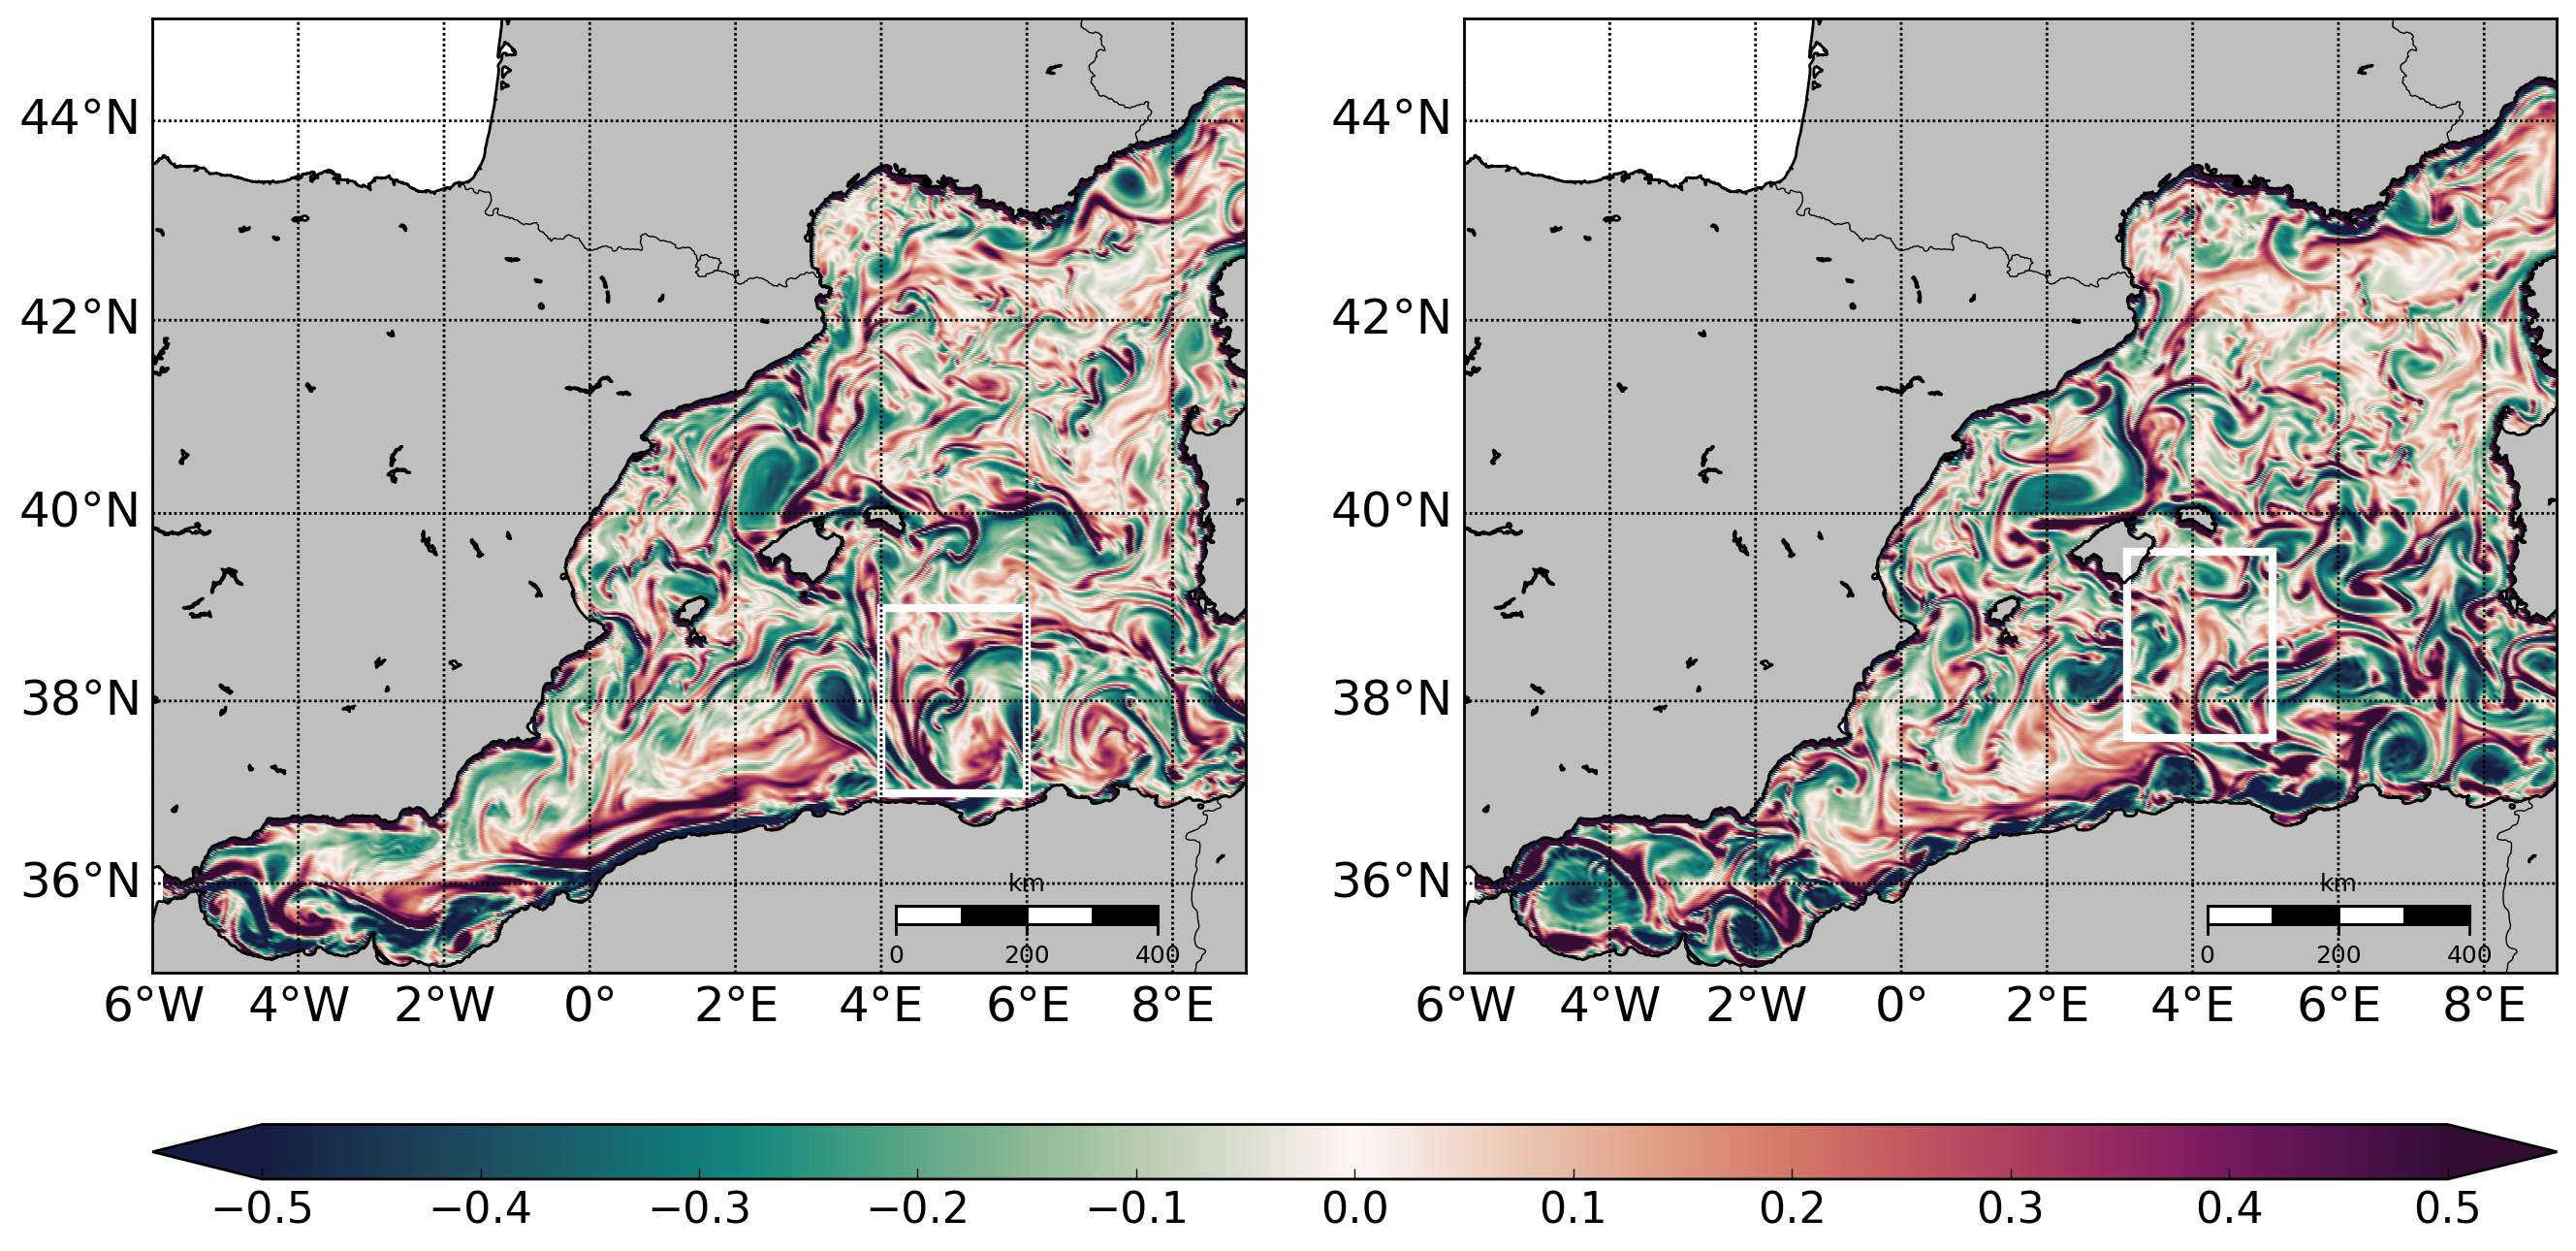

In [21]:
ax1, ax2, my_map1, my_map2 = plot_2_map(lon, lat, rb_1_ma, lon, lat
     , rb_2_ma, box=box_plot, vmin=-.5, vmax=.5, cmap=cmocean.cm.curl)

plot_box( my_map1, ax1, box_p015[0], box_p015[1], box_p015[2], box_p015[3], input_type='coord' )

plot_box( my_map2, ax2, box_p168[0], box_p168[1], box_p168[2], box_p168[3], input_type='coord' )

my_map1.drawmapscale(6., 35.65, 8., 35.7, 400, barstyle='fancy')
my_map2.drawmapscale(6., 35.65, 8., 35.7, 400, barstyle='fancy')

savename = '/Users/laura/Documents/scripts/IMEDEA/figs/new_cutoff_figs/' + 'rel_vort_WMOP_evan_BOX' + '.png'
plt.savefig(str(savename), bbox_inches='tight')